# Data Cleaning

In [6]:
import numpy as np

In [7]:
import pandas as pd

In [8]:
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns

In [9]:
import geopandas as gpd
import pysal
from sklearn.cluster import DBSCAN

In [4]:
import json

In [3]:
import folium

In [8]:
from pointpats import centrography
import contextily as ctx
from shapely.geometry import Point
from matplotlib.patches import Ellipse

In [10]:
# Read in the Hilo foot traffic patterns data
hilo_full = pd.read_parquet('hilo_full_patterns.parquet')

In [8]:
# View the columns
hilo_full.columns

Index(['placekey', 'safegraph_place_id', 'parent_placekey',
       'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids',
       'brands', 'top_category', 'sub_category', 'category_tags', 'naics_code',
       'latitude', 'longitude', 'street_address', 'city', 'region',
       'postal_code', 'iso_country_code', 'phone_number', 'open_hours',
       'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'poi_cbg', 'visitor_daytime_cbgs'],
      dtype='object')

In [9]:
# View the dataset
hilo_full

,placekey,safegraph_place_id,parent_placekey,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,category_tags,...,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type,poi_cbg,visitor_daytime_cbgs
2353,zzw-223@bp4-jct-t5f,sg:a6abadf575c64c7aa2957973c322c258,None,None,YMCA,SG_BRAND_8c40d09d7a855232f6ae8762ffd5966a,YMCA,Individual and Family Services,Other Individual and Family Services,None,...,NaN,NaN,None,None,None,None,None,None,NaN,None
3153,22d-222@bp4-jct-f75,sg:e170329441704027b328f7603705729f,228-222@bp4-jct-hkf,sg:d4f8d56cb61345e6b33a5a1382a503d7,Happy Valley Seafood Restaurant,None,None,Restaurants and Other Eating Places,Full-Service Restaurants,Chinese Food,...,9178.0,14.0,"{""<5"":10,""5-10"":23,""11-20"":11,""21-60"":18,""61-1...",{},"{""CVS"":57,""Target"":49,""7-Eleven"":35,""Walmart"":...","[1,1,0,1,0,0,2,8,6,7,10,13,15,13,9,11,7,3,0,1,...","{""Monday"":13,""Tuesday"":9,""Wednesday"":11,""Thurs...","{""android"":21,""ios"":24}",1.500102e+11,"{""150010210131"":4,""150010207012"":4,""1500102050..."
3422,226-222@bp4-jct-zpv,sg:f6130790a4c7440592d15fe1a58888a6,None,None,Two Ladies Kitchen,None,None,Bakeries and Tortilla Manufacturing,Retail Bakeries,"Dessert,Bakery",...,NaN,NaN,None,None,None,None,None,None,NaN,None
4179,zzy-222@bp4-jcw-xkf,sg:2dc8ca526096494b8694c5ba704704f1,zzw-222@bp4-jfh-47q,sg:5bcbf8781047448ab852bfc69c5c515e,Wailoa River State Recreation Area,None,None,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,None,...,4596.0,47.0,"{""<5"":0,""5-10"":5,""11-20"":15,""21-60"":13,""61-120...","{""Panda Express"":50,""Target"":48}","{""CVS"":51,""Target"":49,""Walmart"":44,""Minit Stop...","[0,1,0,0,0,0,0,13,17,12,18,14,6,4,12,12,8,1,1,...","{""Monday"":6,""Tuesday"":6,""Wednesday"":14,""Thursd...","{""android"":5,""ios"":5}",1.500102e+11,"{""150010211064"":4,""150010205003"":4}"
9436,zzw-223@bp4-jcv-2ff,sg:9ce49fae5cba4828990d087fb1eaaf75,None,None,Hawaii Probation Office,None,None,"Justice, Public Order, and Safety Activities",Courts,None,...,8829.0,63.5,"{""<5"":4,""5-10"":41,""11-20"":20,""21-60"":34,""61-12...","{""7-Eleven"":19,""76"":17,""Starbucks"":11,""Walmart...","{""CVS"":52,""Walmart"":36,""Burger King"":35,""The H...","[0,0,0,0,0,0,21,64,60,67,62,67,59,45,37,33,30,...","{""Monday"":42,""Tuesday"":35,""Wednesday"":56,""Thur...","{""android"":24,""ios"":31}",1.500102e+11,"{""150010205005"":5,""150010204003"":4,""1500102170..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506689,22t-222@bp4-jff-n3q,sg:078a2d1596b0424583304d353abe528b,None,None,Asian Wax Center,None,None,Other Personal Services,All Other Personal Services,None,...,NaN,NaN,None,None,None,None,None,None,NaN,None
507478,22q-223@bp4-jff-mzf,sg:40aff294d9a340819341b03d20269a67,None,None,Puna Chocolate Hilo,None,None,Specialty Food Stores,Confectionery and Nut Stores,None,...,NaN,13.0,"{""<5"":0,""5-10"":1,""11-20"":2,""21-60"":0,""61-120"":...",{},"{""7-Eleven"":64,""CVS"":63,""Target"":62,""Big City ...","[0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0]","{""Monday"":0,""Tuesday"":1,""Wednesday"":0,""Thursda...","{""android"":4,""ios"":0}",1.500102e+11,"{""150010203003"":4}"
514153,zzy-223@bp4-jc3-yy9,sg:23765c32538648149eaf4236c425ed5f,zzw-222@bp4-jc3-pvz,sg:0984fc158b7e447399228335e3ba009d,Ah Lans Leistand,None,None,Florists,Florists,None,...,NaN,NaN,None,None,None,None,None,None,NaN,None
534386,228-222@bp4-jct-hkf,sg:d4f8d56cb61345e6b33a5a1382a503d7,None,None,Hilo Shopping Center,None,None,Lessors of Real Estate,Malls,None,...,16880.0,22.0,"{""<5"":37,""5-10"":470,""11-20"":291,""21-60"":489,""6...","{""Target"":12,""CVS"":11,""76"":8,""7-Eleven"":8,""Pan...","{""CVS"":50,""Target"":42,""Walmart"":41,""76"":31,""Th...","[33,40,42,34,23,20,59,133,156,231,252,281,341,...","{""Monday"":346,""Tuesday"":311,""

In [14]:
# Restructure the dataset so each row represents a place visit

# Make a subset of the dataset
columns_to_keep = ['placekey', 'location_name', 'latitude', 'longitude', 'raw_visit_counts', 'raw_visitor_counts', 'related_same_day_brand']
df_subset = hilo_full[columns_to_keep].copy()

# Fill NaNs in the raw_visit_counts column with zero and make all entries in that column integers 
df_subset['raw_visit_counts'] = pd.to_numeric(df_subset['raw_visit_counts'], errors='coerce').fillna(0).astype(int)

df_subset = df_subset.reset_index(drop=True)

# Use repeat to expand the DataFrame
expanded_df = df_subset.loc[df_subset.index.repeat(df_subset['raw_visit_counts'])].reset_index(drop=True)

In [15]:
# View expanded_df
expanded_df

,placekey,location_name,latitude,longitude,raw_visit_counts,raw_visitor_counts,related_same_day_brand
0,22d-222@bp4-jct-f75,Happy Valley Seafood Restaurant,19.710198,-155.076062,72,45.0,{}
1,22d-222@bp4-jct-f75,Happy Valley Seafood Restaurant,19.710198,-155.076062,72,45.0,{}
2,22d-222@bp4-jct-f75,Happy Valley Seafood Restaurant,19.710198,-155.076062,72,45.0,{}
3,22d-222@bp4-jct-f75,Happy Valley Seafood Restaurant,19.710198,-155.076062,72,45.0,{}
4,22d-222@bp4-jct-f75,Happy Valley Seafood Restaurant,19.710198,-155.076062,72,45.0,{}
...,...,...,...,...,...,...,...
6185756,zzw-225@bp4-jcv-gkz,Haili Christian Preschool,19.722289,-155.088840,48,26.0,"{""Texaco"":50,""CVS"":33}"
6185757,zzw-225@bp4-jcv-gkz,Haili Christian Preschool,19.722289,-155.088840,48,26.0,"{""Texaco"":50,""CVS"":33}"
6185758,zzw-225@bp4-jcv-gkz,Haili Christian Preschool,19.722289,-155.088840,48,26.0,"{""Texaco"":50,""CVS"":33}"
6185759,zzw-225@bp4-jcv-gkz,Haili Christian Preschool,19.722289,-155.088840,48,26.0,"{""Texaco"":50,""CVS"":33}"


In [16]:
print(df_subset['raw_visit_counts'].sum())

6185761


In [17]:
len(expanded_df)

6185761

# General Place Visits Pattern Visualizations

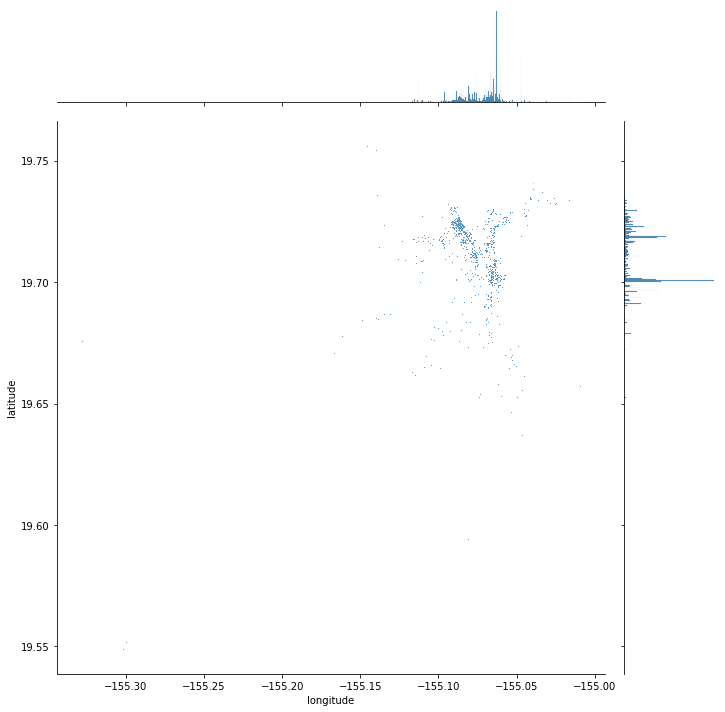

In [29]:
# Point pattern joint plot of longitude and latitude
lat_long_relation = sns.jointplot(
    x="longitude", y="latitude", data=expanded_df, s=0.5, height=10
)
plt.show()

The scatter plot part shows the correlation between the longitude and latitude. The histogram on the sides shows the distribution of each variable independently.

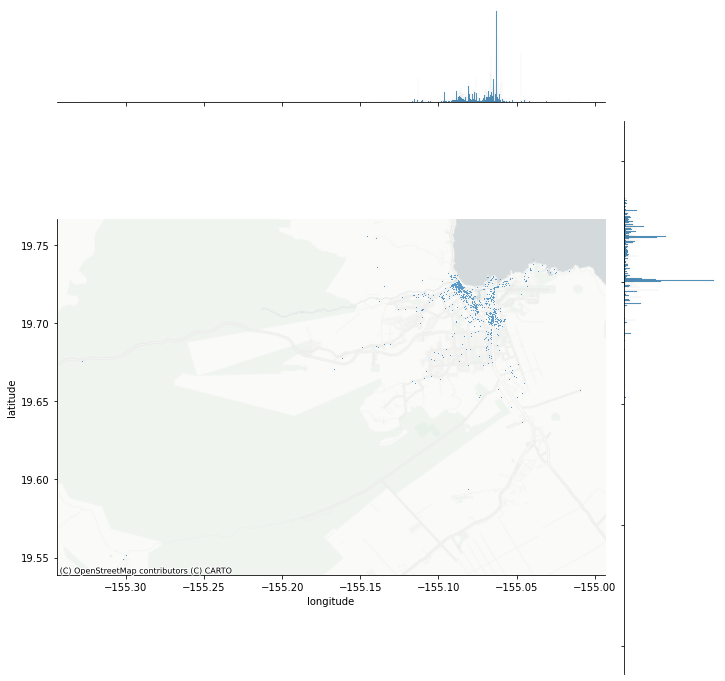

In [37]:
# Add geographical context
joint_axes = sns.jointplot(
    x="longitude", y="latitude", data=expanded_df, s=0.5, height=10
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    alpha=1,
);

We see dots are concentrated in the upper quadrant of the covered area in a non-random pattern and that there are localized clusters within the broader pattern at the top and at the right hand side.

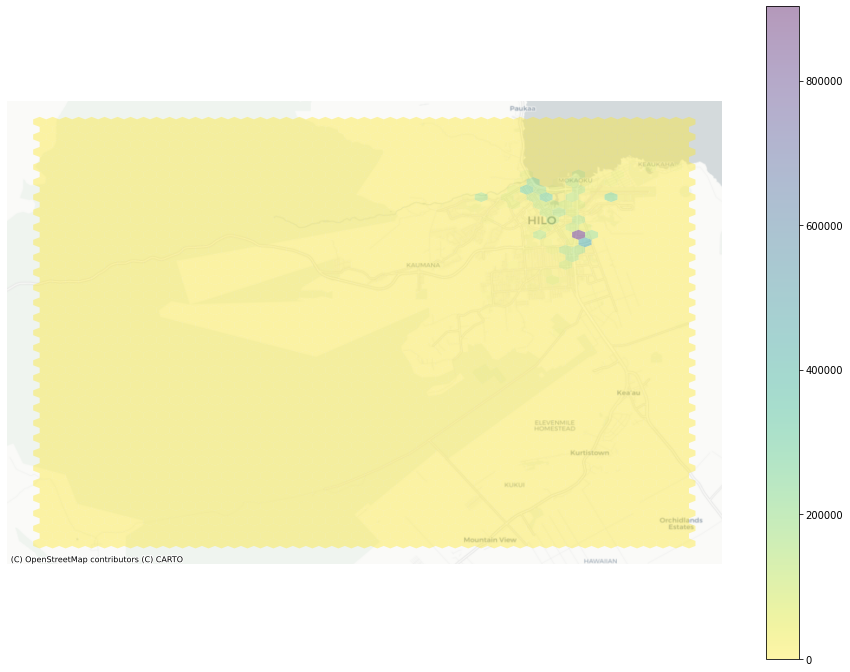

In [39]:
# Address cluttering problem by showing density: Hexbinning
fig, ax = plt.subplots(figsize=(16, 12))

# Generate hexbin map
hilo_full_hxb = ax.hexbin(expanded_df['longitude'], expanded_df['latitude'], gridsize=50, cmap='viridis_r', alpha=0.4, linewidths=0)

# Add basemap
contextily.add_basemap(ax, crs='EPSG:4326', source=contextily.providers.CartoDB.Positron, zoom=12)

plt.colorbar(hilo_full_hxb)
ax.set_axis_off()
plt.show()

In [11]:
# Convert DataFrame to GeoDataFrame for easy CRS management
gdf = gpd.GeoDataFrame(expanded_df, geometry=gpd.points_from_xy(expanded_df.longitude, expanded_df.latitude))
gdf.crs = "EPSG:4326"

# Transform to Web Mercator for compatibility with contextily
gdf = gdf.to_crs(epsg=3857)

In [1]:
# Another type of density visualization: Kernel Density Estimation - run time > 10 min
# Not functional right now

# Set up figure and axis for plotting
f, ax = plt.subplots(1, figsize=(16, 12), dpi=100)

# Plot KDE using the transformed coordinates
sns.kdeplot(
    x=gdf.geometry.x,
    y=gdf.geometry.y,
    fill=True,
    thresh=0,
    levels=10,
    alpha=0.4,
    cmap="viridis_r",
    bw_adjust=0.5,
    ax=ax
)

# Add the basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron, crs="EPSG:3857")

ax.set_axis_off()
#plt.show()

NameError: name 'plt' is not defined

In [13]:
# Check expanded_df for missing or infinite values and drop them if necessary
expanded_df = expanded_df.dropna(subset=['longitude', 'latitude'])
expanded_df = expanded_df[(expanded_df['longitude'] != np.inf) & (expanded_df['latitude'] != np.inf)]
expanded_df = expanded_df[(expanded_df['longitude'] != -np.inf) & (expanded_df['latitude'] != -np.inf)]

In [15]:
# Standard distance calculation - measure of foot traffic dispersion from center of the point cloud

# Transform the CRS to UTM (assuming EPSG:32604 for Hawaii)
gdf_utm = gdf.to_crs("EPSG:32604")

# Extract x and y coordinates from the geometry since std_distance expects numeric inputs
x, y = gdf_utm.geometry.x, gdf_utm.geometry.y

# Calculate the standard distance in the UTM projection
std_distance = centrography.std_distance(np.vstack((x, y)).T)

print(f"The standard distance is approximately {std_distance} meters.")

The standard distance is approximately nan meters.


This means that on average, foot traffic occurs around 2258 meters away from the mean center.

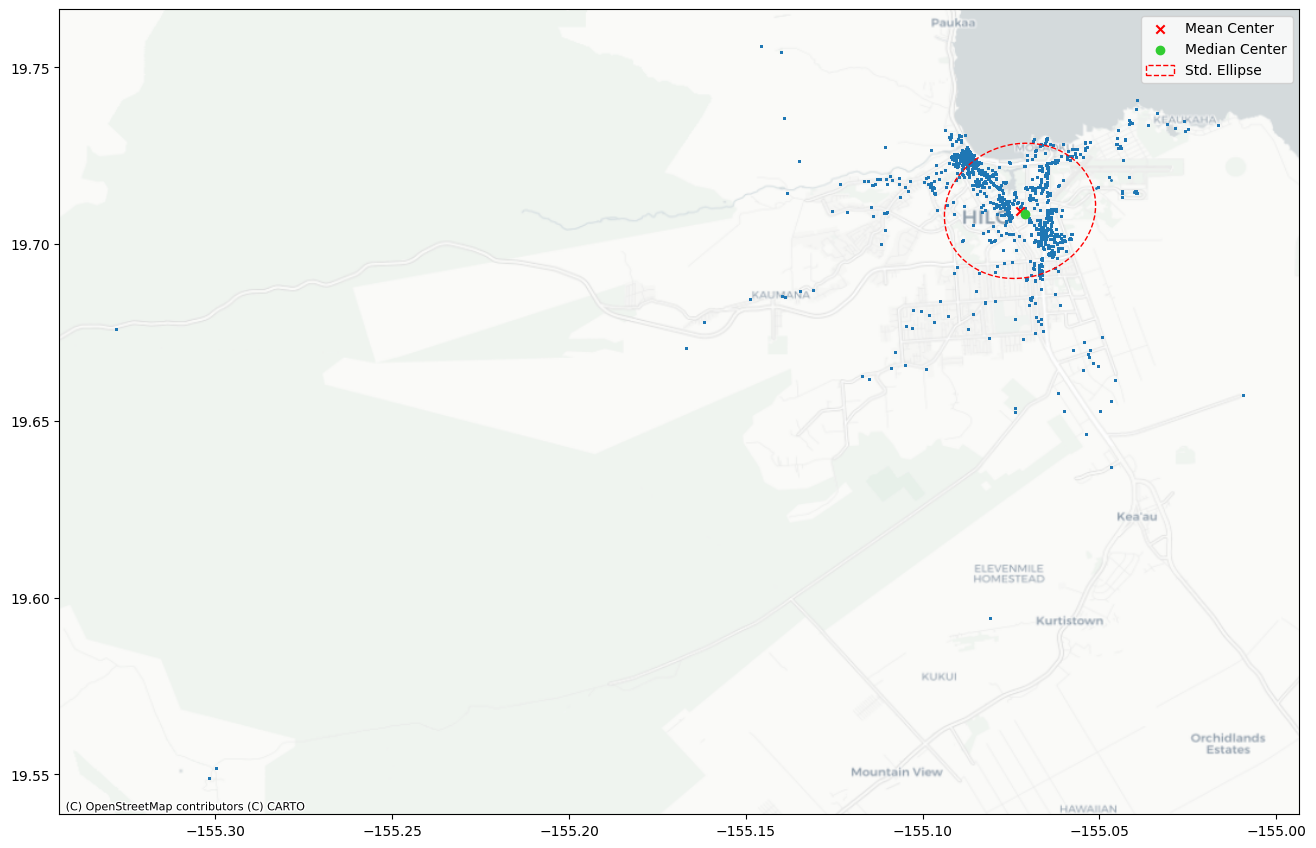

In [152]:
# Standard Deviational Ellipse Graph to evaluate dispersion

# Compute the axes and rotation
major, minor, rotation = centrography.ellipse(expanded_df[["longitude", "latitude"]])

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(16, 12), dpi=100)

# Plot points
ax.scatter(expanded_df["longitude"], expanded_df["latitude"], s=0.5)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(
    *med_center, color="limegreen", marker="o", label="Median Center"
)

# Construct the standard ellipse
ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=np.rad2deg(
        rotation
    ),  
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)

ax.legend()

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.show()

In [ ]:
# DBSCAN Clustering - kills the kernel
# Not functional right now
from sklearn.cluster import DBSCAN

# Optimized DBSCAN fitting with adjusted parameters
clusterer = DBSCAN(eps=0.01, min_samples=10, algorithm='auto')  # Adjust eps and min_samples based on your data
clusterer.fit(expanded_df[['longitude', 'latitude']])
lbls = pd.Series(clusterer.labels_, index=expanded_df.index)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(16, 12), dpi=100)

# Subset points that are not part of any cluster (noise)
noise = expanded_df.loc[lbls == -1, ["longitude", "latitude"]]

# Plot noise in grey
ax.scatter(noise["longitude"], noise["latitude"], c=lbls, s=5, cmap='viridis', linewidth=0)

# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron, crs='EPSG:4326'
)


ax.set_axis_off()
plt.show()

# Related same day brand visit analysis

In [35]:
# Top 10 businesses with the highest visit counts
hilo_full.sort_values(by="raw_visit_counts", ascending=False)["location_name"].unique()[:10]

array(['Waiakea Center', 'Hilo International Airport',
       'Prince Kuhio Plaza', 'Walmart', 'Target',
       'University Of Hawaii At Hilo', 'Hilo Medical Center',
       'The Home Depot', 'CVS', 'Kta Puainako Pharmacy'], dtype=object)

In [13]:
# Top 10 stores with the highest number of associations with other brands visited by the same customers on the same day
hilo_full.sort_values(by="related_same_day_brand", ascending=False)["location_name"].unique()[:10]

array(['Happy Valley Seafood Restaurant', 'Nakashima Neal K DMD',
       'East Hawaii Acupuncture', 'Old Hawaiian Bed & Breakfast',
       'Brittain Jacqueline PHD', 'So Juicy Hilo', 'St Joseph School',
       'Pharmacare Hawaii', 'Cupcakes BOOM', "Remy's Plate Lunch"],
      dtype=object)

In [14]:
# Top related same day brand for the top 10 businesses with the highest visit counts
import json

# Top 10 businesses with the highest visit counts
#businesses = ['Waiakea Center', 'Hilo International Airport', 'Prince Kuhio Plaza', 
#              'Walmart', 'Target', 'University Of Hawaii At Hilo', 
#              'Hilo Medical Center', 'The Home Depot', 'CVS', 
#              'Kta Puainako Pharmacy']

top_related_brands = {}

for business in highest_visits_twenty:
    # Filter for the current business
    business_data = hilo_full[hilo_full['location_name'] == business].copy()
    
    # Safely convert the JSON string in related_same_day_brand to a list, handling None values
    business_data['related_same_day_brand_list'] = business_data['related_same_day_brand'].apply(
        lambda x: json.loads(x) if x is not None else []
    )
    
    # Explode the DataFrame so each brand has its own row
    all_related_brands = business_data.explode('related_same_day_brand_list')
    
    # Count the most common related same-day brand
    if not all_related_brands.empty:
        top_brand = all_related_brands['related_same_day_brand_list'].value_counts().idxmax()
    else:
        top_brand = 'No data'
    
    # Store the result in the dictionary
    top_related_brands[business] = top_brand

for business, top_brand in top_related_brands.items():
    print(f"{business}: {top_brand}")

Waiakea Center: Walmart
Hilo International Airport: CVS
Prince Kuhio Plaza: CVS
Walmart: CVS
Target: CVS
University Of Hawaii At Hilo: Target
Hilo Medical Center: CVS
The Home Depot: Target
CVS: Target
Kta Puainako Pharmacy: CVS


# Working Functions

In [30]:
# Function to create a df for top businesses with highest visit counts and their top related brands

def find_top_businesses_with_related_brands(data):
    # Step 1: Identify the top ~10 businesses by visit counts
    # Now using 'safegraph_place_id' to ensure unique identification of places
    top_visited = data.sort_values(by='raw_visit_counts', ascending=False).drop_duplicates(subset='safegraph_place_id')
    top_visited = top_visited.head(10)
    
    # Initialize a list to hold the result
    results = []

    # Step 2: For each of the top 10 businesses, find the top related brand based on visit counts
    for index, business in top_visited.iterrows():
        # Parse the JSON data in the 'related_same_day_brand' column
        try:
            related_brands = json.loads(business['related_same_day_brand'])
        except json.JSONDecodeError:
            related_brands = {}

        related_brands_df = pd.DataFrame(list(related_brands.items()), columns=['Brand', 'Count'])
        top_related = related_brands_df.sort_values(by='Count', ascending=False).head(1)
        
        for i, row in top_related.iterrows():
            # Find the matching business entry for the related brand using 'location_name'
            # This assumes that 'location_name' can still uniquely identify related brands for fetching latitude and longitude
            related_brand_info = data[data['location_name'] == row['Brand']].iloc[0]
            result = {
                'Safegraph Place ID': business['safegraph_place_id'],  # Include safegraph_place_id
                'Main Business': business['location_name'],
                'Main Latitude': business['latitude'],
                'Main Longitude': business['longitude'],
                'Related Brand': row['Brand'],
                'Related Brand Latitude': related_brand_info['latitude'],
                'Related Brand Longitude': related_brand_info['longitude']
            }
            results.append(result)
    
    return pd.DataFrame(results)

In [31]:
# Example function usage
top_businesses_related_brands = find_top_businesses_with_related_brands(hilo_full)
top_businesses_related_brands

,Safegraph Place ID,Main Business,Main Latitude,Main Longitude,Related Brand,Related Brand Latitude,Related Brand Longitude
0,sg:20ef6cb67d8044a8819242b88ea0382d,Waiakea Center,19.700528,-155.062836,Walmart,19.700208,-155.061990
1,sg:233e22fd43c045068caa4ebb0d50dfd6,Prince Kuhio Plaza,19.696705,-155.063336,CVS,19.719114,-155.080965
2,sg:e94865836761404c88783262889769da,Walmart,19.700208,-155.061990,Target,19.701079,-155.060065
3,sg:7d6d3d1141b54069a25505c520b82caf,Target,19.701079,-155.060065,CVS,19.719114,-155.080965
4,sg:3597c36840414287a1a3ca04d92c0b49,University Of Hawaii At Hilo,19.700514,-155.080721,Safeway,19.700470,-155.060697
5,sg:6e05b546b9f94607a9562385f2595e4a,Hilo Medical Center,19.718494,-155.112909,CVS,19.719114,-155.080965
6,sg:a59a77f25593461f9eb9d7d4a1919118,The Home Depot,19.698058,-155.059361,Walmart,19.700208,-155.061990
7,sg:67245b251c3046beabbe31e530a6da4b,CVS,19.696084,-155.061919,Walmart,19.700208,-155.061990
8,sg:6dbef0623590420385f65cafb0208ba7,Kta Puainako Pharmacy,19.693967,-155.066875,CVS,19.719114,-155.080965


In [32]:
# Create a base map
def generate_base_map(default_location=[37.77, -122.41], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

# Assuming the DataFrame 'top_businesses_related_brands' has been created as you described
top_businesses_related_brands = find_top_businesses_with_related_brands(hilo_full)

# Generate a map, you might need to adjust the default location to fit your data
map = generate_base_map(default_location=[top_businesses_related_brands['Main Latitude'].mean(), top_businesses_related_brands['Main Longitude'].mean()])

In [33]:
# Function to add markers to the map
def add_points_to_map(df, map_obj):
    # Adding markers for main businesses
    for _, row in df.iterrows():
        if pd.notna(row['Main Latitude']) and pd.notna(row['Main Longitude']):
            folium.Marker(
                location=[row['Main Latitude'], row['Main Longitude']],
                popup=f"Main Business: {row['Main Business']}",
                icon=folium.Icon(color='red')  # Red for main businesses
            ).add_to(map_obj)

        # Check if related brand information exists and add markers
        if pd.notna(row['Related Brand Latitude']) and pd.notna(row['Related Brand Longitude']):
            folium.Marker(
                location=[row['Related Brand Latitude'], row['Related Brand Longitude']],
                popup=f"Related Brand: {row['Related Brand']}",
                icon=folium.Icon(color='blue')  # Blue for related brands
            ).add_to(map_obj)

In [34]:
# Example usage
# Generate the map
map = generate_base_map(default_location=[top_businesses_related_brands['Main Latitude'].mean(), top_businesses_related_brands['Main Longitude'].mean()])

# Add points to the map
add_points_to_map(top_businesses_related_brands, map)

# Display the map
map

In [55]:
import requests
import pandas as pd
import polyline

In [56]:
#pip install polyline

In [57]:
def compute_fastest_foot_routes(df):
    routes = []
    osrm_url = "http://router.project-osrm.org/route/v1/foot/"

    for index, row in df.iterrows():
        if pd.notna(row['Main Latitude']) and pd.notna(row['Main Longitude']) and pd.notna(row['Related Brand Latitude']) and pd.notna(row['Related Brand Longitude']):
            request_url = f"{osrm_url}{row['Main Longitude']},{row['Main Latitude']};{row['Related Brand Longitude']},{row['Related Brand Latitude']}?overview=full"  # 'full' for complete route geometry
            try:
                response = requests.get(request_url)
                response.raise_for_status()
                route_data = response.json()

                if 'routes' in route_data and route_data['routes']:
                    first_route = route_data['routes'][0]
                    geometry = first_route.get('geometry')  # This is often an encoded polyline
                    decoded_geometry = polyline.decode(geometry)  # Decoding the polyline to a list of (lat, lon) tuples
                    
                    route_info = {
                        'Main Business': row['Main Business'],
                        'Related Brand': row['Related Brand'],
                        'Distance': first_route['distance'],
                        'Duration': first_route['duration'],
                        'Geometry': decoded_geometry  # Store the decoded geometry
                    }
                    routes.append(route_info)
                else:
                    print(f"No route found for {row['Main Business']} to {row['Related Brand']}")
            except requests.RequestException as e:
                print(f"Request failed: {e}")
    
    return pd.DataFrame(routes)

In [58]:
fastest_foot_routes_df = compute_fastest_foot_routes(top_businesses_related_brands)
print(fastest_foot_routes_df)

                  Main Business Related Brand  Distance  Duration  \
0                Waiakea Center       Walmart      43.3      12.7   
1            Prince Kuhio Plaza           CVS    3775.3     362.1   
2                       Walmart        Target    1039.5     149.1   
3                        Target           CVS    3865.8     393.5   
4  University Of Hawaii At Hilo       Safeway    3946.5     447.3   
5           Hilo Medical Center           CVS    4295.4     466.1   
6                The Home Depot       Walmart     587.4      98.5   
7                           CVS       Walmart     616.1     155.1   
8         Kta Puainako Pharmacy           CVS    3355.8     323.9   

                                            Geometry  
0  [(19.70049, -155.06284), (19.70049, -155.06265...  
1  [(19.69658, -155.06295), (19.69652, -155.06295...  
2  [(19.70027, -155.06265), (19.70015, -155.06267...  
3  [(19.70136, -155.06007), (19.70137, -155.05973...  
4  [(19.70025, -155.08124), (19.70

In [59]:
import folium
import itertools

In [60]:
def plot_routes_on_map(df_routes):
    # Define a list of colors for different routes
    colors = itertools.cycle(['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'lightgreen', 'gray', 'black', 'pink'])
    
    # Create the base map
    if not df_routes.empty:
        first_lat = df_routes.iloc[0]['Geometry']['coordinates'][0][1]
        first_lon = df_routes.iloc[0]['Geometry']['coordinates'][0][0]
        map = folium.Map(location=[first_lat, first_lon], zoom_start=12)
        
        # Add a legend to the map
        legend_html = '''
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 150px; height: 90px; 
                    border:2px solid grey; z-index:9999; font-size:14px;
                    ">&nbsp; <b>Legend</b> <br>
                      &nbsp; Main Business &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i><br>
                      &nbsp; Related Brand &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i>
        </div>
        '''
        map.get_root().html.add_child(folium.Element(legend_html))

        # Add the routes to the map
        for index, row in df_routes.iterrows():
            route_color = next(colors)  # Get a color from the cycle
            popup_text = f"Route from {row['Main Business']} to {row['Related Brand']}"
            route_line = folium.PolyLine(
                locations=[(lat, lon) for lon, lat in row['Geometry']['coordinates']],
                weight=5,
                color=route_color,
                popup=folium.Popup(popup_text, parse_html=True)  # Add popup to the route
            ).add_to(map)

            # Add markers for the start (main business) and end (related brand) points
            folium.Marker(
                location=[row['Geometry']['coordinates'][0][1], row['Geometry']['coordinates'][0][0]],
                popup=f"{row['Main Business']}",
                icon=folium.Icon(color='red')
            ).add_to(map)

            folium.Marker(
                location=[row['Geometry']['coordinates'][-1][1], row['Geometry']['coordinates'][-1][0]],
                popup=f"{row['Related Brand']}",
                icon=folium.Icon(color='blue')
            ).add_to(map)

        return map
    else:
        print("No routes to display.")
        return None

In [62]:
plot_routes_on_map(fastest_foot_routes_df)

TypeError: list indices must be integers or slices, not str

# Appendix 

In [15]:
# Top 10 related same day brands for the top 10 businesses with the highest visit counts
import json

# Top 10 businesses with the highest visit counts
businesses = ['Waiakea Center', 'Hilo International Airport', 'Prince Kuhio Plaza', 
              'Walmart', 'Target', 'University Of Hawaii At Hilo', 
              'Hilo Medical Center', 'The Home Depot', 'CVS', 
              'Kta Puainako Pharmacy']

top_related_brands = {}

for business in businesses:
    # Filter for the current business
    business_data = hilo_full[hilo_full['location_name'] == business].copy()
    
    # Safely convert the JSON string in related_same_day_brand to a list, handling None values
    business_data['related_same_day_brand_list'] = business_data['related_same_day_brand'].apply(
        lambda x: json.loads(x) if x is not None else []
    )
    
    # Explode the DataFrame so each brand has its own row
    all_related_brands = business_data.explode('related_same_day_brand_list')
    
    # Count the most common related same-day brand
    if not all_related_brands.empty:
        top_brand = all_related_brands['related_same_day_brand_list'].value_counts().nlargest(3)
    else:
        top_brand = 'No data'
    
    # Store the result in the dictionary
    top_related_brands[business] = top_brand

for business, top_brand in top_related_brands.items():
    print(f"{business}: {top_brand}")

Waiakea Center: related_same_day_brand_list
Walmart    38
Texaco     38
Target     38
Name: count, dtype: int64
Hilo International Airport: related_same_day_brand_list
CVS       12
Target     5
76         4
Name: count, dtype: int64
Prince Kuhio Plaza: related_same_day_brand_list
CVS          38
Starbucks    38
Target       34
Name: count, dtype: int64
Walmart: related_same_day_brand_list
CVS               35
Target            34
The Home Depot    19
Name: count, dtype: int64
Target: related_same_day_brand_list
CVS               28
Walmart           27
The Home Depot    11
Name: count, dtype: int64
University Of Hawaii At Hilo: related_same_day_brand_list
Target     15
CVS         8
Walmart     5
Name: count, dtype: int64
Hilo Medical Center: related_same_day_brand_list
CVS        21
Target      7
Beltone     3
Name: count, dtype: int64
The Home Depot: related_same_day_brand_list
Target     33
CVS        30
Walmart    27
Name: count, dtype: int64
CVS: related_same_day_brand_list
Target

In [32]:
# Function to create a new df for a business with location coordinates

def create_location_df(dataframe, location_name):
    # Filter for the given location_name
    location_filter = dataframe[dataframe["location_name"] == location_name]
    
    # Select only the relevant columns
    location_df = location_filter[['location_name', 'latitude', 'longitude']].copy()
    
    # Drop rows with NaN values in 'latitude' or 'longitude'
    location_df = location_df.dropna(subset=['latitude', 'longitude'])
    
    # Drop duplicate rows based on 'latitude' and 'longitude' to ensure unique locations
    unique_location_df = location_df.drop_duplicates(subset=['latitude', 'longitude'])
    
    return unique_location_df

In [117]:
# Create a df for the top related same day visit brands and their locations

# Target
target_df = create_location_df(hilo_full, "Target")
print(target_df.head())

# CVS
cvs_df = create_location_df(hilo_full, "CVS")
print(cvs_df.head()) # contains repeats (google maps says there's only 2 or 3 CVS?)

# Walmart
walmart_df = create_location_df(hilo_full, "Walmart")
print(walmart_df.head())

# Texaco
texaco_df = create_location_df(hilo_full, "Texaco")
print(texaco_df.head())

# Starbucks
starbucks_df = create_location_df(hilo_full, "Starbucks")
print(starbucks_df.head())

# The Home Depot
home_depot_df = create_location_df(hilo_full, "The Home Depot")
print(home_depot_df.head())

       location_name   latitude   longitude
484294        Target  19.701079 -155.060065
       location_name   latitude   longitude
401958           CVS  19.719114 -155.080965
105879           CVS  19.714147 -155.096465
406005           CVS  19.717002 -155.098303
408026           CVS  19.696084 -155.061919
250631           CVS  19.701053 -155.060014
       location_name   latitude  longitude
121882       Walmart  19.700208 -155.06199
       location_name   latitude   longitude
54133         Texaco  19.721794 -155.078254
294048        Texaco  19.699592 -155.063167
526716        Texaco  19.684861 -155.069312
503306        Texaco  19.723539 -155.088302
       location_name   latitude   longitude
98138      Starbucks  19.719484 -155.082527
463780     Starbucks  19.700554 -155.061079
142493     Starbucks  19.700952 -155.060247
188685     Starbucks  19.698700 -155.061641
         location_name   latitude   longitude
547299  The Home Depot  19.698058 -155.059361


In [138]:
# Create a merged df with all the top related same day visit brands and their locations
top_related_six = pd.concat([target_df, cvs_df, walmart_df, texaco_df, starbucks_df, home_depot_df], ignore_index=True)
print(top_related_six)
# Lots of repeats, will filter through these later

     location_name   latitude   longitude
0           Target  19.701079 -155.060065
1              CVS  19.719114 -155.080965
2              CVS  19.714147 -155.096465
3              CVS  19.717002 -155.098303
4              CVS  19.696084 -155.061919
5              CVS  19.701053 -155.060014
6          Walmart  19.700208 -155.061990
7           Texaco  19.721794 -155.078254
8           Texaco  19.699592 -155.063167
9           Texaco  19.684861 -155.069312
10          Texaco  19.723539 -155.088302
11       Starbucks  19.719484 -155.082527
12       Starbucks  19.700554 -155.061079
13       Starbucks  19.700952 -155.060247
14       Starbucks  19.698700 -155.061641
15  The Home Depot  19.698058 -155.059361


In [97]:
# Create a df with top 10 most visited businesses and their corresponding locations

# Create an empty df
top_visits_ten = pd.DataFrame()

# Get the names of the top 10 most visited businesses
top_ten_business_names = hilo_full.sort_values(by="raw_visit_counts", ascending=False)["location_name"].unique()[:10]

# Temporary list to collect DataFrames
temp_dfs = []

for business in top_ten_business_names:
    business_data = hilo_full[hilo_full["location_name"] == business]
    # Sort and take the first row with the highest "raw_visit_counts"
    top_business_data = business_data.sort_values(by="raw_visit_counts", ascending=False).head(1)
    # Collect the top row for each business
    temp_dfs.append(top_business_data)

# Concatenate all the top rows into a single DataFrame
top_visits_ten = pd.concat(temp_dfs)

# Reset index after concatenating
top_visits_ten.reset_index(drop=True, inplace=True)

# Drop any rows with NaN values in 'latitude' or 'longitude'
top_visits_ten = top_visits_ten.dropna(subset=['latitude', 'longitude'])

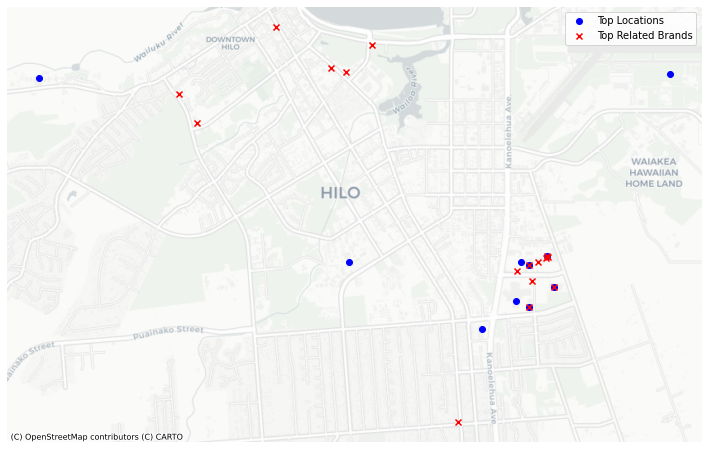

In [128]:
# Basic plot of TOP 6 related same day brands visited and
# top 10 highest foot traffic businesses (w/o labels)

# Convert df to Geo df
gdf = gpd.GeoDataFrame(top_visits_ten, geometry=gpd.points_from_xy(top_visits_ten.longitude, top_visits_ten.latitude))
gdf_related_brands = gpd.GeoDataFrame(top_related_selected, geometry=gpd.points_from_xy(top_related_selected.longitude, top_related_selected.latitude))

# Set CRS to WGS84
gdf.crs = "EPSG:4326"
gdf_related_brands.crs = "EPSG:4326"

# Convert to Web Mercator for mapping with contextily basemap
gdf = gdf.to_crs(epsg=3857)
gdf_related_brands = gdf_related_brands.to_crs(epsg=3857)

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 8))

# Plot top locations
gdf.plot(ax=ax, color='blue', marker='o', label='Top Locations')

# Plot related brands
gdf_related_brands.plot(ax=ax, color='red', marker='x', label='Top Related Brands')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()

plt.legend()
plt.show()

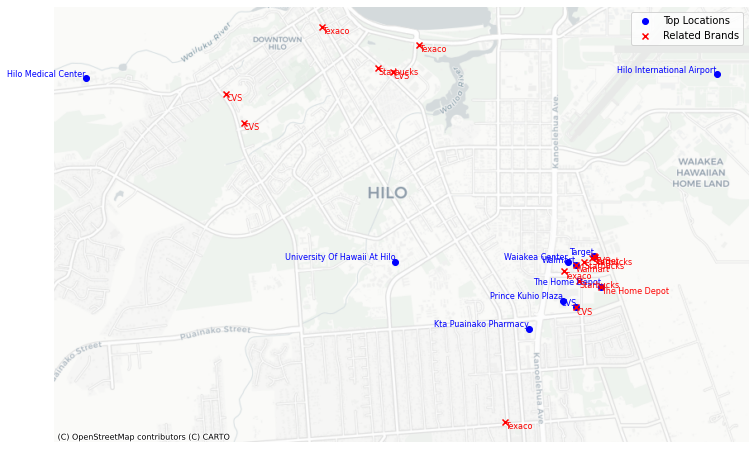

In [134]:
# Basic plot of related same day brand visits and
# top 10 highest foot traffic businesses (w/ labels)

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 8))

# Plot top locations
gdf.plot(ax=ax, color='blue', marker='o', label='Top Locations')

# Plot related brands
gdf_related_brands.plot(ax=ax, color='red', marker='x', label='Related Brands')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Track labeled names to ensure each name is only shown once
labeled_names = set()

# Add labels for top locations
for idx, row in gdf.iterrows():
    name = row['location_name']
    # Check if the name has already been labeled
    ax.text(row.geometry.x, row.geometry.y, s=name, fontsize=8, ha='right', va='bottom', color='blue')

top_location_names = gdf['location_name'].unique().tolist()

# Add labels for related brands, ensuring each name is shown only once
for idx, row in gdf_related_brands.iterrows():
    name = row['location_name']
    # Only label if the name hasn't been labeled yet
    ax.text(row.geometry.x, row.geometry.y, s=name, fontsize=8, ha='left', va='top', color='red')

ax.set_axis_off()
plt.legend()
plt.show()

In [136]:
# Create a merged df with the TOP 3 top related same day visit brands and their locations
top_related_three = pd.concat([target_df, cvs_df, walmart_df], ignore_index=True)
top_related_selected = top_related_three.loc[[0, 4, 5, 6]] # only keeping the reasonable 2 CVS

print(top_related_selected)

  location_name   latitude   longitude
0        Target  19.701079 -155.060065
4           CVS  19.696084 -155.061919
5           CVS  19.701053 -155.060014
6       Walmart  19.700208 -155.061990


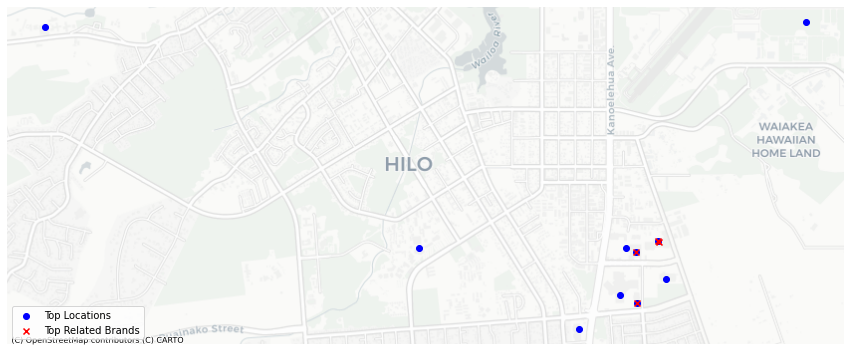

In [145]:
# Basic plot of TOP 3 related same day brands visited and
# top 10 highest foot traffic businesses (w/o labels)

# Convert df to Geo df
gdf = gpd.GeoDataFrame(top_visits_ten, geometry=gpd.points_from_xy(top_visits_ten.longitude, top_visits_ten.latitude))
gdf_related_brands = gpd.GeoDataFrame(top_related_selected, geometry=gpd.points_from_xy(top_related_selected.longitude, top_related_selected.latitude))

# Set CRS to WGS84
gdf.crs = "EPSG:4326"
gdf_related_brands.crs = "EPSG:4326"

# Convert to Web Mercator for mapping with contextily basemap
gdf = gdf.to_crs(epsg=3857)
gdf_related_brands = gdf_related_brands.to_crs(epsg=3857)

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Plot top locations
gdf.plot(ax=ax, color='blue', marker='o', label='Top Locations')

# Plot related brands
gdf_related_brands.plot(ax=ax, color='red', marker='x', label='Top Related Brands')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()

plt.legend()
plt.show()

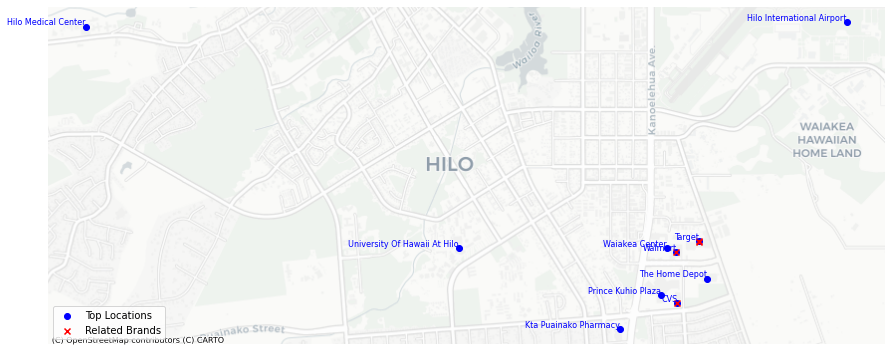

In [144]:
# Basic plot of related same day brand visits and
# top 10 highest foot traffic businesses (w/ labels)

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Plot top locations
gdf.plot(ax=ax, color='blue', marker='o', label='Top Locations')

# Plot related brands
gdf_related_brands.plot(ax=ax, color='red', marker='x', label='Related Brands')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Add labels for top locations
for idx, row in gdf.iterrows():
    name = row['location_name']
    # Check if the name has already been labeled
    ax.text(row.geometry.x, row.geometry.y, s=name, fontsize=8, ha='right', va='bottom', color='blue')

ax.set_axis_off()
plt.legend()
plt.show()